In [121]:
import wandb
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import DictConfig, OmegaConf
api = wandb.Api()

In [126]:
entity, project = "lazaric", "MAB Project"  # set to your entity and project 
runs = api.runs(entity + "/" + project) 
print(f"Total number of runs {len(runs)}")

# number of pulls per arm
pulls = {}

# reward per step
rewards = {}

# max expected reward
max_value = {}

# number of steps of the experiment
n_steps = {}

for run in runs: 
    if run.state == "finished":
        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        cfg = OmegaConf.create({k: v for k,v in run.config.items()
            if not k.startswith('_')})
        run_config = (cfg.environment.name, str(cfg.algorithm.scaling))
        #print(OmegaConf.to_yaml(cfg))

        # extract summary variables
        summary = run.summary._json_dict
        # extract all statistics
        scan_history = run.scan_history()
        
        # compute the largest expected value (create only once since all runs with the same environment and scaling should have the same best arm)
        if run_config not in max_value:
            max_value[run_config] = np.array([arm["mean"] for arm in cfg.environment.arms]).max()

        # read the number of pulls at the end of the experiment
        if run_config not in pulls:
            pulls[run_config] = []
        pulls[run_config].append([summary["n_pulls0"], summary["n_pulls1"]])

        # read the reward per step
        if run_config not in rewards:
            rewards[run_config] = []
        rewards[run_config].append([row["reward"] for row in scan_history])



Total number of runs 30


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


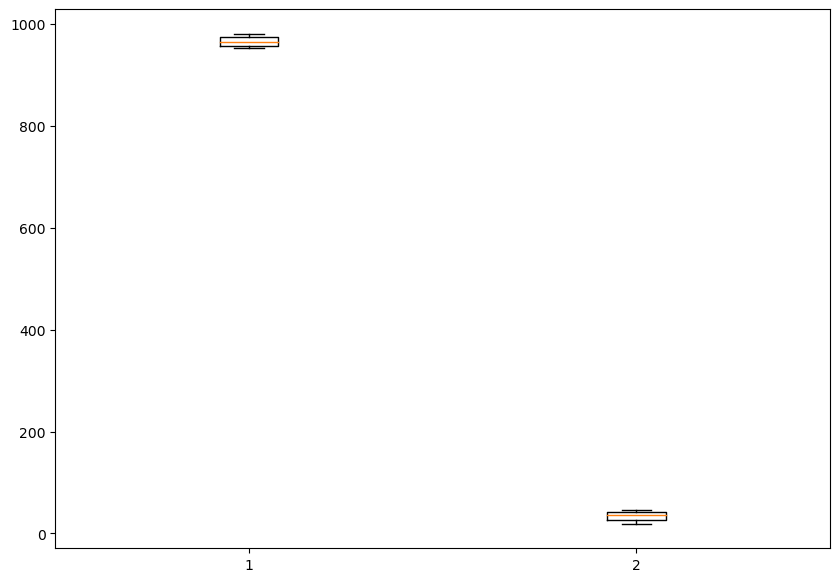

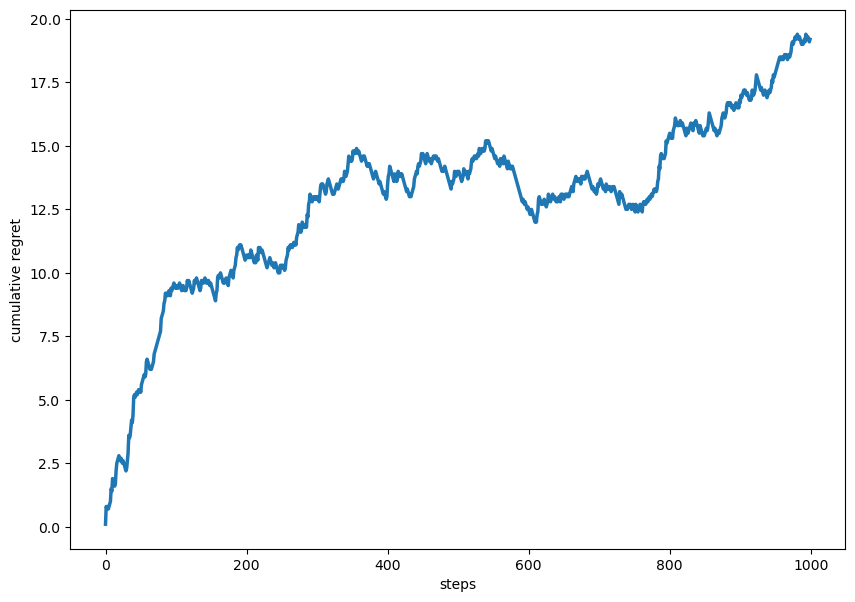

In [128]:
experiment_key = ("bernoulli_easy","1")
pulls_experiment = np.array(pulls[experiment_key])

cum_rewards = np.cumsum(np.array(rewards[experiment_key]).mean(axis=0))
n_steps = len(cum_rewards)
cum_regret = np.arange(1,n_steps+1) * max_value[experiment_key] - cum_rewards

fig = plt.figure(figsize =(10, 7))
# creating pulls plot
plt.boxplot(pulls_experiment)

# creating regret plot
fig = plt.figure(figsize =(10, 7))
plt.legend(loc='upper left', frameon=False)
plt.xlabel("steps")
plt.ylabel("cumulative regret")
plt.plot(np.arange(n_steps), cum_regret, linewidth=2.5, linestyle="-")

# show plots
plt.show()